In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score,learning_curve, GroupKFold,GridSearchCV
from sklearn.metrics import confusion_matrix



In [2]:
df =  pd.read_csv('../2017_07_07/TADPOLE_D1_D2.csv',low_memory=False)

In [3]:
#Name of the columns
df.head(0)


,RID,PTID,VISCODE,SITE,D1,D2,COLPROT,ORIGPROT,EXAMDATE,DX_bl,...,PHASE_UPENNBIOMK9_04_19_17,BATCH_UPENNBIOMK9_04_19_17,KIT_UPENNBIOMK9_04_19_17,STDS_UPENNBIOMK9_04_19_17,RUNDATE_UPENNBIOMK9_04_19_17,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,COMMENT_UPENNBIOMK9_04_19_17,update_stamp_UPENNBIOMK9_04_19_17


In [4]:
#Do some test on the data

print(df['DX'].head())
print(df['DX_bl'].head())
print(df['EXAMDATE_BAIPETNMRC_09_12_16'].unique())
print(df['PTETHCAT'].head(1))

0          NL
1    Dementia
2    Dementia
3    Dementia
4    Dementia
Name: DX, dtype: object
0    CN
1    AD
2    AD
3    AD
4    AD
Name: DX_bl, dtype: object
['2005-09-22' '2006-03-13' '2006-09-12' ... '2016-04-21' '2016-04-12'
 '2016-04-27']
0    Not Hisp/Latino
Name: PTETHCAT, dtype: object


In [5]:
pd.set_option('display.max_columns', None)

#important columns to convert to int: EXAMDATE	DX_bl	DXCHANGE	AGE	PTGENDER	PTEDUCAT	PTETHCAT	PTRACCAT	PTMARRY	

In [6]:
print(df['DXCHANGE'].head(1))
'1=Stable:NL to NL, 2=Stable:MCI to MCI, 3=Stable:AD to AD, ' 
'4=Conv:NL to MCI, 5=Conv:MCI to AD, 6=Conv:NL to AD, ' 
'7=Rev:MCI to NL, 8=Rev:AD to MCI, 9=Rev:AD to NL, -1=Not available'

0    1.0
Name: DXCHANGE, dtype: float64


'7=Rev:MCI to NL, 8=Rev:AD to MCI, 9=Rev:AD to NL, -1=Not available'

In [19]:
data = df
print(data.shape)

#Convert to numeric
data['PTGENDER']= data['PTGENDER'].replace(['Male','Female'],[1,0])
data['APOE4']= data['APOE4'].astype(float)
data['AGE']= data['AGE'].astype(float)
data['PTETHCAT']= data['PTETHCAT'].replace(['Hisp/Latino','Not Hisp/Latino','Unknown'],[2,1,0]).astype(int)
data['PTMARRY']= data['PTMARRY'].replace(['Married','Widowed','Divorced','Never married','Unknown'],[0,1,2,3,4]).astype(int)
data['PTRACCAT'] = data['PTRACCAT'].replace(['White','More than one','Black','Asian', 'Am Indian/Alaskan','Hawaiian/Other PI', 'Unknown'],[0,1,2,3,4,5,6]).astype(int)
data['DX_bl'] = data['DX_bl'].replace(['CN' ,'AD' ,'LMCI' ,'EMCI' ,'SMC'],['0','1','2','3','4']).astype(int)
df['DX'] = df['DX'].replace(['NL' ,'Dementia', 'MCI', 'NL to MCI', 'MCI to Dementia', 'MCI to NL','Dementia to MCI','nan' ,'NL to Dementia'],['1','3','4','5','6','7','8','9','10'])
df['DX']=df['DX'].fillna(0)

#Print some data to check if it is correct
print(data['DX_bl'].head())
print(data['DX'].unique())

# drop the columns in data they ate objet type
data = data.select_dtypes(exclude=['object'])
print(data.shape)


(12741, 1907)
0    0
1    1
2    1
3    1
4    1
Name: DX_bl, dtype: int32
['1' '3' '4' '5' '6' '7' '8' 0 '10']
(12741, 85)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12741 entries, 0 to 12740
Data columns (total 85 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   RID                       12741 non-null  int64  
 1   SITE                      12741 non-null  int64  
 2   D1                        12741 non-null  int64  
 3   D2                        12741 non-null  int64  
 4   DX_bl                     12741 non-null  int32  
 5   DXCHANGE                  8892 non-null   float64
 6   AGE                       12741 non-null  float64
 7   PTGENDER                  12741 non-null  int64  
 8   PTEDUCAT                  12741 non-null  int64  
 9   PTETHCAT                  12741 non-null  int32  
 10  PTRACCAT                  12741 non-null  int32  
 11  PTMARRY                   12741 non-null  int32  
 12  APOE4                     12729 non-null  float64
 13  FDG                       3352 non-null   float64
 14  PIB   

In [20]:
# Algorithme des k plus proches voisins
model = KNeighborsClassifier()
y = data['DXCHANGE']
Y = data['DX_bl']
X = data.drop('DXCHANGE', axis=1)
y = np.nan_to_num(y)
X= np.nan_to_num(X)
Y = np.nan_to_num(Y)

In [21]:

#Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

model.fit(X_train,Y_train)
print(model.score(X_train,Y_train))
print(model.score(X_test,Y_test))

0.7055533751962323
0.5810121616320125
0.8235871271585558
0.6963515103962338


In [11]:
#Take the best parameters for the model
param_grid = {'n_neighbors': np.arange(1, 25),'metric': ['euclidean', 'manhattan']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)


C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [22]:

grid2 = grid
grid2.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [12]:
# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

model = grid.best_estimator_
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))


{'metric': 'manhattan', 'n_neighbors': 1}
0.6400125905971918
KNeighborsClassifier(metric='manhattan', n_neighbors=1)
1.0
0.6673205178501374


In [23]:
# Print the tuned parameters and score of the current diagnostic
print(grid2.best_params_)
print(grid2.best_score_)
print(grid2.best_estimator_)

model = grid2.best_estimator_
print(model.score(X_train,Y_train))
print(model.score(X_test,Y_test))

{'metric': 'manhattan', 'n_neighbors': 1}
0.8799064464723948
KNeighborsClassifier(metric='manhattan', n_neighbors=1)
1.0
0.9187916830129462


In [13]:
#View the error of the model
confusion_matrix(y_test, model.predict(X_test))


array([[513,  78, 123,  38,   1,   9,   0,   3,   0],
       [ 87, 418,  27,   8,   8,   0,   0,   6,   1],
       [129,  23, 569,  24,   6,  33,   0,   8,   1],
       [ 57,  12,  35, 192,   0,  23,   0,   0,   0],
       [  6,   8,   8,   1,   1,   0,   0,   0,   0],
       [  9,   4,  36,  22,   0,   5,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   1,   7,   0,   2,   0,   0,   3,   0],
       [  0,   0,   0,   1,   0,   1,   0,   0,   0]], dtype=int64)

In [24]:

confusion_matrix(Y_test, model.predict(X_test))


array([[766,   5,  16,  13,   4],
       [ 28, 216,  28,   8,   0],
       [ 18,  28, 904,   7,   1],
       [ 10,   4,  10, 412,   6],
       [ 10,   3,   5,   3,  44]], dtype=int64)

In [14]:
#the learning curve
N, train_score,val_score = learning_curve(model,X_train,y_train,train_sizes = np.linspace(0.2,1.0,5),cv=5)

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [25]:
#the learning curve
N2, train_score2,val_score2 = learning_curve(model,X_train,Y_train,train_sizes = np.linspace(0.2,1.0,5),cv=5)

[1630 3261 4891 6522 8153]


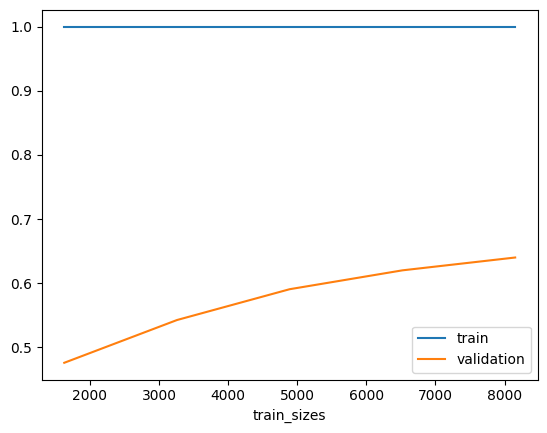

In [15]:
#Plot the learning curve
print(N)
plt.plot(N,train_score.mean(axis=1), label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()


[1630 3261 4891 6522 8153]


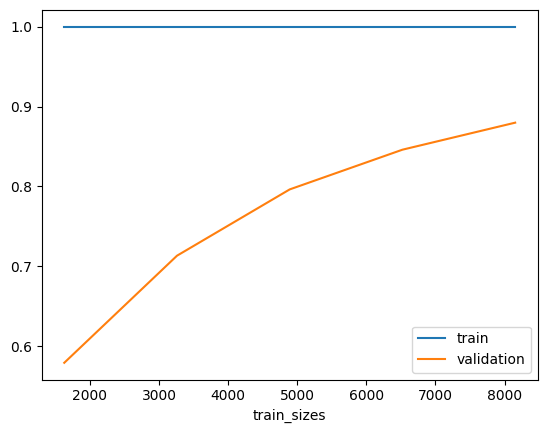

In [26]:
#Plot the learning curve
print(N2)
plt.plot(N2,train_score.mean(axis=1), label='train')
plt.plot(N2,val_score2.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [16]:
#Chose the best split for the data
cv =  GroupKFold(5).get_n_splits(X,y,groups=X[:,5])
cross_val_score(model,X,y,cv=cv)

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


array([0.33424872, 0.39207221, 0.34144427, 0.4678179 , 0.49018838])

In [17]:
def sick(model,PTGENDER=1,AGE=10,PTEDUCAT=4,APOE4=0):
    x= np.array([PTGENDER,AGE,PTEDUCAT,APOE4]).reshape(1,4)
    print(model.predict(x))
    print(model.predict_proba(x))